In [1]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold

loaded_data = joblib.load("train_data.pkl")

targets, data, ids = loaded_data

# 打印某个人的具体信息

for i in tqdm(range(277)):
    if ids[i] == "44a41bba1ee7":
        print(f"Target: {targets[i]}")
        print(f"{data[i]}")
        print(type(targets[i]))
        print(type(data[i]))

100%|██████████| 277/277 [00:00<00:00, 16741.20it/s]

Target: [(6228, 12324), (22044, 28248), (59016, 65064), (78024, 82068), (95400, 99444), (109956, 114480), (126780, 132972), (144984, 151944), (191376, 199020), (211716, 217476), (243036, 251184)]
           anglez      enmo      step
0       26.234375  0.142456       0.0
1       25.828125  0.142456       1.0
2       25.687500  0.140015       2.0
3       26.640625  0.141968       3.0
4       26.140625  0.154053       4.0
...           ...       ...       ...
328135  -2.517578  0.027496  328135.0
328136 -10.000000  0.016602  328136.0
328137 -12.046875  0.015198  328137.0
328138 -12.585938  0.013901  328138.0
328139 -16.937500  0.013000  328139.0

[328140 rows x 3 columns]
<class 'list'>
<class 'pandas.core.frame.DataFrame'>


In [2]:
class CFG:
    window_overlap = 30
    window_size = 60
    train_ratio = 0.80
    batch_size = 32
    input_dim = 2
    embed_dim = 32
    num_classes = 3 
    num_layers = 6
    nhead = 4
    dim_feedforward = 64
    learning_rate = 1e-3
    epochs = 200
    train_record_steps = 160
    test_record_steps = 20
    dropout = 0.4
    num_person = 277
    scheduler_step_size = 20
    scheduler_gamma = 0.8
    fold = 8
    weight_decay = 0.001
    model_dir = "./models"

In [ ]:
# 生成放入模型的数据，假设使用30分钟作为一个窗口，那么需要找的为形状（360，2）的矩阵

train_events = pd.read_csv("./train_events.csv")
num_person = len(train_events["series_id"].unique())
print("The number of total persons is:", num_person)

# 用来存储模型的输入与标签
X = []
y = []

for i in tqdm(range(min(num_person, CFG.num_person))):

    df = data[i]
    pair_list = targets[i]
    sleep_id = ids[i]

    # 先提取出开始睡觉和结束睡觉的时间
    onset_steps = []
    wakeup_steps = []
    for j in range(len(pair_list)):
        onset_steps.append(pair_list[j][0])
        wakeup_steps.append(pair_list[j][1])
    # print("length of onset list:", len(onset_steps))
    # print("length of wakeup list:", len(wakeup_steps))
    # print(onset_steps)
    # print(wakeup_steps)

    # 中间没有明确时间点的区间全部都不要
    empty_spaces = []
    events = train_events[train_events["series_id"] == sleep_id]
    last_events = 0
    mark = 0 
    for (idx, row) in events.iterrows():
        if np.isnan(row["step"]):
            mark = 1
        else:
            if row["step"] > last_events and mark == 0:
                last_events = row["step"]
            elif row["step"] > last_events and mark == 1:
                empty_spaces.append((int(last_events + 720), int(row["step"] - 720)))
                last_events = row["step"]
                mark = 0

    # print(empty_spaces)

    # 为训练数据设置label，如果区间中没有任何事件，标签为0，如果有开始睡觉事件，标签为1，如果有结束睡觉事件，标签为2
    labels = []
    for j in range(0, len(df), CFG.window_overlap):
        start = j
        if j + CFG.window_size >= len(df):
            break
        else:
            end = j + CFG.window_size

        flag = 0
        for k in empty_spaces:
            if (k[0] <= start <= k[1]) or (k[0] <= end <= k[1]):
                flag = 1
                break
            else:
                continue

        chunk = df.iloc[start:end][["anglez", "enmo"]]
        chunk = chunk.to_numpy()

        if flag == 1:
            label = 3
        elif any(start <= num <= end for num in wakeup_steps):
            label = 2
        elif any(start <= num <= end for num in onset_steps):
            label = 1
        else:
            label = 0
        labels.append(label)

        if label != 3:
            X.append(chunk)
            y.append(label)

    element_counts = Counter(labels)

    # for element, count in element_counts.items():
    #     print(f"Element {element} occurs {count} times")

print(len(X), len(y))

In [4]:
X_noevent = []
y_noevent = []
X_onset = []
y_onset = []
X_wakeup = []
y_wakeup = []

for i in tqdm(range(len(X))):
    xi = X[i]
    yi = y[i]
    if yi == 0:
        X_noevent.append(xi)
        y_noevent.append(yi)
    elif yi == 1:
        X_onset.append(xi)
        y_onset.append(yi)
    elif yi == 2:
        X_wakeup.append(xi)
        y_wakeup.append(yi)

print(len(X_noevent), len(X_onset), len(X_wakeup))

X_noevent = X_noevent[:max(len(X_onset, X_wakeup))]
y_noevent = y_noevent[:max(len(X_onset, X_wakeup))]
X = X_noevent + X_onset + X_wakeup
y = y_noevent + y_onset + y_wakeup

print(len(X), len(y))

100%|██████████| 665874/665874 [00:00<00:00, 1761751.35it/s]


661760 2055 2059
14514 14514


In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        inp = self.inputs[index]
        output = self.outputs[index]

        input_tensor = torch.tensor(inp, dtype=torch.float32)
        output_tensor = torch.tensor(output, dtype=torch.long)

        return input_tensor, output_tensor


dataset = MyDataset(X, y)
print(len(dataset))

# train_size = int(CFG.train_ratio * len(dataset))
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True)
# print(len(train_loader), len(test_loader))

14514
363 91


In [6]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        num_classes=3,
        num_layers=8,
        nhead=4,
        dim_feedforward=64,
        dropout=0.4
    ):

        super(TransformerModel, self).__init__()

        self.conv1d = nn.Conv1d(
            in_channels=input_dim, 
            out_channels=embed_dim, 
            kernel_size=3, 
            padding=1
        )
        self.embed_layer = nn.Linear(embed_dim, embed_dim)
        self.layernorm = nn.LayerNorm(embed_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )

        self.classification = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)

        x = self.embed_layer(x)
        x = self.layernorm(x)
        x = self.encoder(x.permute(1, 0, 2))
        print(x.shape)
        x = x[-1]
        x = self.classification(x)
        return x

# 示例
model = TransformerModel(input_dim=2, embed_dim=32)
input_data = torch.rand(3, 360, 2)
output = model(input_data)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(output.shape)

TransformerModel(
  (conv1d): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (embed_layer): Linear(in_features=32, out_features=32, bias=True)
  (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (classification): Linear(in_features=32, out_features=3, bias=True)
)
Total 

In [7]:
model = TransformerModel(
    input_dim=CFG.input_dim,
    embed_dim=CFG.embed_dim,
    num_classes=CFG.num_classes,
    num_layers=CFG.num_layers,
    nhead=CFG.nhead,
    dim_feedforward=CFG.dim_feedforward,
    dropout=CFG.dropout
)

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 35619


In [ ]:
train_losses = []
train_step_losses = []
test_losses = []
test_step_losses = []
learning_rates = []

kf = KFold(n_splits=CFG.fold, shuffle=True, random_state=2023)

for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    train_loader = DataLoader(train_subset, batch_size=CFG.batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=CFG.batch_size)

    train_model = model.to(device=device)
    train_model.train()

    init_lr = CFG.learning_rate

    # if fold == 0:
    #     optimizer = torch.optim.Adam(
    #         model.parameters(),
    #         lr=init_lr,
    #         weight_decay=CFG.weight_decay
    #     )
    # else:
    #     # current_learning_rate = optimizer.param_groups[0]["lr"]
    #     # print("current learning rate is:", current_learning_rate)
    #     optimizer = torch.optim.Adam(
    #         model.parameters(),
    #         lr=init_lr / (1.25 ** fold),
    #         weight_decay=CFG.weight_decay
    #     )

    optimizer = torch.optim.Adam(train_model.parameters(), lr=CFG.learning_rate)
    scheduler = StepLR(optimizer, step_size=CFG.scheduler_step_size, gamma=CFG.scheduler_gamma)

    min_loss = 10000.0

    for epoch in range(1, CFG.epochs + 1):
        train_loss = 0.0
        test_loss = 0.0
        train_step_loss = 0.0
        test_step_loss = 0.0


        learning_rate = optimizer.param_groups[0]["lr"]
        learning_rates.append(learning_rate)

        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            optimizer.zero_grad()

            data = data.to(device)
            target = target.to(device)
            output = train_model(data)

            loss = criterion(output, target)
            train_loss += loss.item()
            train_step_loss += loss.item()

            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % CFG.train_record_steps == 0:
                train_step_loss /= CFG.train_record_steps
                train_step_losses.append(train_step_loss)
                print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Step: {(batch_idx + 1) * CFG.train_record_steps}, Train Loss These Steps: {train_step_loss}")
                train_step_loss = 0.0

        scheduler.step()

        with torch.no_grad():
            for batch_idx, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
                data = data.to(device)
                target = target.to(device)
                output = train_model(data)

                loss = criterion(output, target)
                test_loss += loss.item()
                test_step_loss += loss.item()

                if (batch_idx + 1) % CFG.test_record_steps == 0:
                    test_step_loss /= CFG.test_record_steps
                    test_step_losses.append(test_step_loss)
                    print(f"Fold: {fold + 1}, Epoch: {epoch + 1}, Step: {(batch_idx + 1) * CFG.test_record_steps}, Test Loss These Steps: {test_step_loss}")
                    test_step_loss = 0.0

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)

        if test_loss < min_loss:
            min_loss = test_loss
            torch.save(train_model.state_dict(), f"{CFG.model_dir}/model_{fold + 1}.pth")


        print(f"Fold: {fold + 1}, Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")

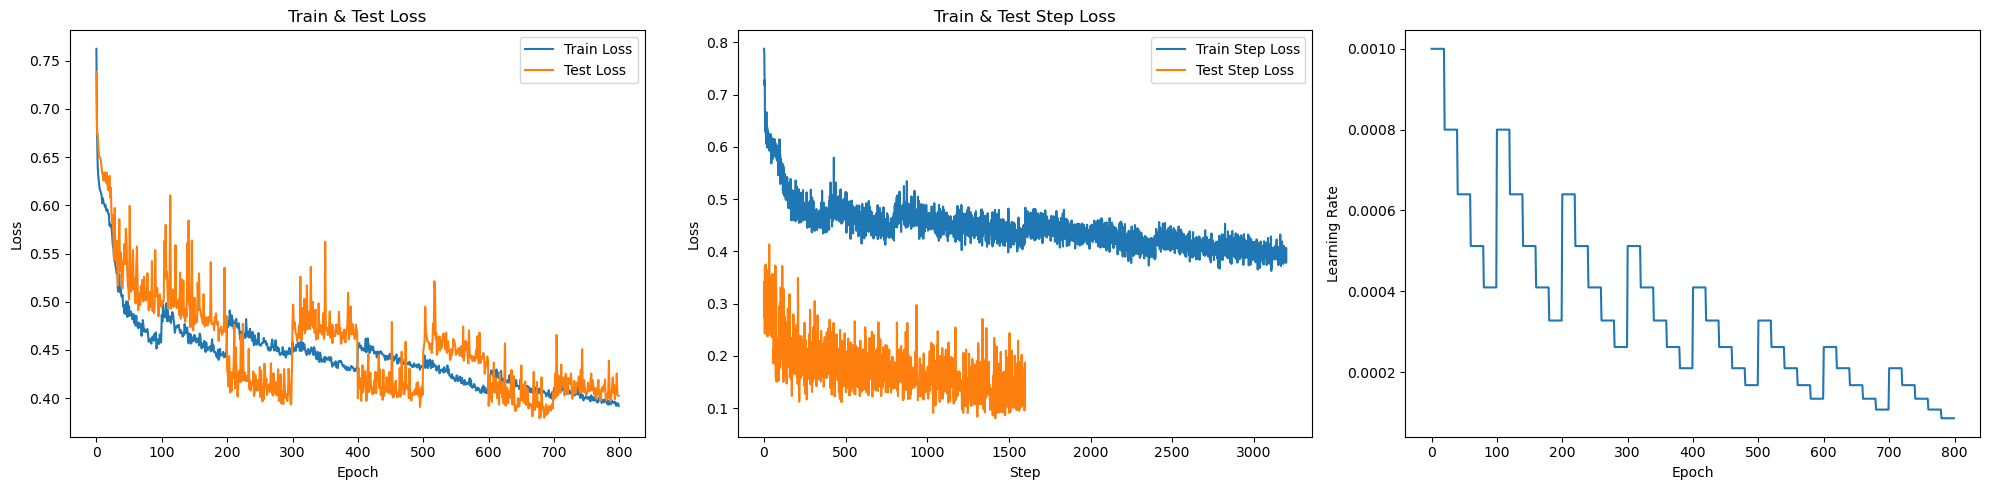

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_step_losses, label="Train Step Loss")
plt.plot(test_step_losses, label="Test Step Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Train & Test Step Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")

plt.savefig("plot.png")

plt.tight_layout()
plt.show()